In [1]:
%matplotlib inline
import numpy as np
import pyross
import matplotlib.pyplot as plt
from scipy.io import loadmat
np.set_printoptions(precision=2)
plt.rcParams.update({'font.size': 26})

In [2]:
def get_CM(CH, CA, M, H, H1=10):
    """
    returns the big contact matrix
    Paramets
    CH: home contacts
    CA: away contacts
    M: age-groups
    H: number of house
    """
    C = np.zeros((M*H, M*H))

    for i in range(H):
        for j in range(H):
            if i==j:
                for ii in range(M):
                    for jj in range(M):
                        # diagonal block matrices
                        C[i*M+ii, j*M+jj] = CH[ii, jj]
            else:
                if np.random.randint(1000)<H1:  #+np.random.randint(10)
                    for ii in range(M):
                        for jj in range(M):
                            C[i*M+ii, j*M+jj] = CA[ii, jj]
    return C


def get_data(contactMatrix, x0, Ni):
    beta  = 0.005           # probability of infection on contact 
    gIa   = 1./14            # removal rate of asymptomatic infectives 
    gE    = 1/4.72          # removal rate of exposeds
    gIs   = 1./14            # removal rate of symptomatic infectives 
    alpha = 0.              # asymptomatic fraction
    fsa   = 1               # suppresion of contact by symptomatics

    parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,'gE':gE,'fsa':fsa}
    model = pyross.deterministic.SEIR(parameters, Ni.size, Ni)


    # start simulation
    Tf, Nf =120,120; 
    data = model.simulator(x0, contactMatrix, Tf, Nf, integrator='odespy')
    return model.Is(data), model.R(data)

## Varying contact matrices to study the role of closing schools

In [3]:
M = 2      # two age groups
H = 512      # number of meta-houses
Hc = 20      # number of household contact per 1000

Ni = np.zeros(M*H)
Ni[0::M]=3
Ni[1::M]=5


# initial conditions  
Is_0 = np.zeros((M*H));  Is_0[0::32]=3; 
E_0  = np.zeros((M*H));  
x0   = np.concatenate(( Ni-(Is_0 + E_0), E_0, Is_0*0, Is_0))

In [7]:
CH = np.array(( [3., 1.], [1., 2.] ))
CA = np.array(( [12., 1.], [1., 3.] ))
C = get_CM(CH, CA, M, H, Hc)

def contactMatrix(t):   
    return C
I1, R1  = get_data(contactMatrix, x0, Ni)

 
CA = np.array(( [0., 1.], [6., 3.] ))
C2 = get_CM(CH, CA, M, H, Hc)
def contactMatrix(t):   
    if t<20:
        return C
    else:
        return C2
I2, R2  = get_data(contactMatrix, x0, Ni)

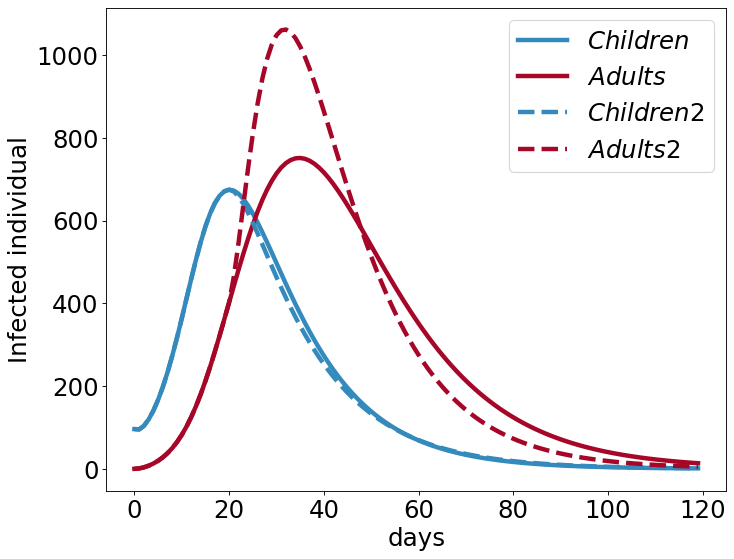

In [8]:
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

plt.plot(np.sum(I1[:,0::M], axis=1), '-', color="#348ABD", label='$Children$', lw=4)
plt.plot(np.sum(I1[:,1::M], axis=1), '-', color='#A60628', label='$Adults$', lw=4)

plt.plot(np.sum(I2[:,0::M], axis=1), '--', color="#348ABD", label='$Children2$', lw=4)
plt.plot(np.sum(I2[:,1::M], axis=1), '--', color='#A60628', label='$Adults2$', lw=4)
plt.legend(); plt.ylabel('Infected individual'); plt.xlabel('days');

In [9]:
print ('Childs, case 1', np.sum(R1[-1][0::M]))
print ('Childs, case 2', np.sum(R2[-1][0::M]))
print()
print ('Adults, case 1', np.sum(R1[-1][1::M]))
print ('Adults, case 2', np.sum(R2[-1][1::M]))

Childs, case 1 1533.2830905296796
Childs, case 2 1493.7906925594643

Adults, case 1 2363.918547891555
Adults, case 2 2517.4651635405007
